<a href="https://colab.research.google.com/github/Threebodyman1/project1/blob/main/AlphaFold3_Colab_b1.2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##AlphaFold3 Colab Beta v1.2.0

This project is aimed to provide a ColabFold-like interface for people who are used to ColabFold. You need to request your own parameters and download the ~600GB database in order for this to work properly.

Easy to use protein structure and complex prediction using [AlphaFold3](https://www.nature.com/articles/s41586-024-07487-w). Sequence alignments/templates are automatically generated using built in function by AlphaFold 3 if not specified. For more details, visit [AlphaFold3 GitHub](https://github.com/google-deepmind/alphafold3/tree/main).

Some code and packages were adopted from ColabFold 1.5.5, see [ColabFold](https://github.com/sokrypton/ColabFold)

In [1]:
#@title Setup the Folders (Run this first, ~ 10s)
import os
import IPython
import json
try:
  os.makedirs("inputs")
except:
  pass
try:
  os.makedirs("outputs")
except:
  pass
try:
  os.makedirs("templates")
except:
  pass
try:
  os.makedirs("msa")
except:
  pass
try:
  os.makedirs("userCCD")
except:
  pass
try:
  os.makedirs("1_Results")
except:
  pass

if not os.path.isfile("baisc_READY"):
  os.system("pip install --upgrade pip")
  os.system("pip install py3Dmol")
  os.system("pip install matplotlib")
  os.system("touch baisc_READY")
else:
  pass

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -U --no-deps 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

IPython.display.clear_output()

In [2]:
os.path.isfile("COLABFOLD_READY")

True

In [3]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
import os
import numpy as np
from IPython.display import clear_output
import ast
import json
chain_str = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
chain_list = list(chain_str)
del chain_str

#@markdown **Basic** settings
#@markdown ---
jobname = 'XHY052521_73dd2' #@param {type:"string"}
query_sequences = 'CIGYHANNSTDTVDTVLEKNVTVTHSVNLLEDKHNGKLCKLKGVAPLHLGQCNIAGWILGNPECESLSTARSWSYIVETSNSDNGTCYPGDFINYEELRELLSSVSSFERFEIFPKTSSWPNHDSDNGVTAACSHAGERSFYKNLIWLVKKGKSYPKINQTYINDKGKEVLVLWGIHHPPTITDQESLYQNADAYVFVGTSRYSKKFKPEIAARPKVRDQAGRMNYYWTLVEPGDKITFEATGNLVAPRYAFTMEKEAGSGIIISDTPVHDCNATCQTPEGAINTSLPFQNVHPITIGKCPKYVRSTKLRLATGLRNVPSIQSRGLFGAIAGFIEGGWTGMVDGWYGYHHQNDQGSGYAADLKSTQNAIDKITNKVNSVIEKMNTQFTAVGKEFNHLEKRIENLNKKVDDGFLDVWTYNAELLVLLENERTLDYHDSNVKNLYEKVRHQLKNNAKEIGNGCFEFYHKCDNTCMESVKNGTYDYPKYSEEAKLKREKIDGVKLDSTR' #@param {type:"string"}
multimer_identifer = "3" #@param {type:"string"}
#@markdown - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports hetro-oligomers). For example **PI...SK:AG...LQ** for a hetro-oligomer
#@markdown - If is homo-oligomer, specify how many copy exists in multimer_identifier, seperated by `:`. For example `2:2` for a dimer for sequence in each chain break. Use `1` for a monomer.

query_type_identifer = "P" #@param {type:"string"}
#@markdown - `P` for protein, `R` for RNA, `D` for DNA, `L` for Ligands, `LS` for Ligands using simles definition, `I` for Ions.
#@markdown - Use `:` to specify inter-protein chainbreaks for **modeling complexes**, same format as above.

type_identifer = {"P": "protein", "R": "rna", "D": "dna", "L": "ligand", "LS": "ligand","I": "ion"}
seq_header_identifer = {"P": "sequence", "R": "sequence", "D": "sequence", "L": "ccdCodes", "LS": "smiles", "I": "ccdCodes"}

#@markdown ---
#@markdown **Modification** settings
#@markdown ---

modifications = "" #@param {type:"string"}
modifications = modifications.replace(" ", "")
modifications = modifications.replace("\\", "")

#@markdown - Post-translational modifications, for each chain split.
#@markdown - Using impossible PTMs will end up with errors in folding!
#@markdown - Use `:` to specify inter-protein chainbreaks for **modeling complexes**, same format as above.
#@markdown - Use list like format, for example `"HY3", 1; "P1L", 5:"P1L", 6`.
#@markdown - Could be left completely empty, else the number of `:` have to match the number of chain breaks.
#@markdown - Only use Modification for P, R and D, else will report error in folding.

#@markdown ---
#@markdown **MSA** settings
#@markdown ---

msa_mode = "A" #@param {type:"string"}
#@markdown - `A` for `auto`, `N` for `none`, `C` for `custom`
#@markdown - `auto` AlphaFold 3 will build the MSA automatically. This is the recommended option.
#@markdown - `none` AlphaFold 3 will not build the MSA and the MSA input to the model will be empty for all chains.
#@markdown - `custom` AlphaFold 3 will use the provided MSA instead of building one as part of the data pipeline. Also recommended if possible.
#@markdown - MSA searching speed is limited by disk reading speed. (Will take forever on HDD)
#@markdown - If left empty, will do auto for all chains
#@markdown - Use `:` to specify mode for each chain break.
#@markdown - Example: `A:C:N`
custom_unpaired_msa = "\"XHY052521_73dd2.a3m\"" #@param {type:"string"}
custom_paired_msa = "" #@param {type:"string"}

custom_unpaired_msa = custom_unpaired_msa.replace("\\", "").replace('"', "")
custom_paired_msa = custom_paired_msa.replace("\\", "").replace('"', "")

custom_unpaired_msa = custom_unpaired_msa.replace(" ", "")
custom_paired_msa = custom_paired_msa.replace(" ", "")

if msa_mode == "":
  msa_mode = "A:" * (len(query_sequences.split(":")))
  msa_mode = msa_mode[:-1]

#@markdown - Only used if `msa_mode` is set to `custom`.
#@markdown - Only one of the unpaired and paired will be used, unpaired is better.
#@markdown - Use `:` to specify MSA for each chain break.
#@markdown - This is specified by inputing the name of the A3M file (equivalent to the FASTA format, but also allows gaps denoted by the hyphen - character)
#@markdown - Example: `"file1.a3m":"file2.a3m"`
#@markdown - Put the a3m files into the folder `msa/`
#@markdown - Left blank to ignore. Numbers of chain break `:` must match the query if `msa_mode` is not empty.
#@markdown - You can use the a3m files generated by colab fold here!

#@markdown ---
#@markdown **Template** settings
#@markdown ---

templates = "" #@param {type:"string"}
templates = templates.replace("\\", "")
templates = templates.replace(" ", "")

if templates == "":
  templates = ":" * (len(query_sequences.split(":")) - 1)

#@markdown - Left blank to ignore using templates.
#@markdown - A template is specified as an mmCIF name containing a single chain with the structural template together zero indexing.
#@markdown - Use `:` to split between query protein chains.
#@markdown - Use `;` to split between different templates in each chain break.
#@markdown - Example: `"file1.cif";"file2.cif":"file3.cif"`
#@markdown - Use `;` to split between different templates in each chain break.
#@markdown - Put the cif files into the folder `templates/`
#@markdown - If templates is set, them the amount of `:` must match the query sequences. You can define `""` if you don't want to use template for a specifc chain.

queryIndices = "" #@param {type:"string"}
templateIndices = "" #@param {type:"string"}
queryIndices = queryIndices.replace("\\", "")
queryIndices = queryIndices.replace(" ", "")
templateIndices = templateIndices.replace("\\", "")
templateIndices = templateIndices.replace(" ", "")

#@markdown - Use `:` to split between query protein chains, only used when templates are specifed.
#@markdown - Use `;` to split between different templates in each chain break.
#@markdown - Use `,` to split between each indices.
#@markdown - Example: `0, 1, 4;1, 3, 4:0, 1, 3`
#@markdown - If templates is set, them the amount of `:` must match the query sequences.

#@markdown ---
#@markdown **Bond** settings
#@markdown ---

bond = "" #@param {type:"string"}
#@markdown - Allow you to specify some bonds that AF3 will definitely connect them in folding.
#@markdown - Specify in a list format, for example:
#@markdown - `[["A", 12, "SG"], ["B", 1, "C04"]], [["C", 1, "O6"], ["D", 2, "C1"]]`
#@markdown - Means to connect chain A, residue #12 atom SG to chain B, residue 1 atom C04 ...
#@markdown - The id of the chain is arranged by chain break in your query sequence.
#@markdown - `multimer_identifer` will have effect. Going from "A, B ,C ,D...", a chain id is assigned in sequence for each object in your complex.

#@markdown ---
#@markdown **userCCD** settings
#@markdown ---

userCCD = "" #@param {type:"string"}
#@markdown - Define a particular ligand using the CCD mmCIF format
#@markdown - Put the cif files into the folder `userCCD/`
#@markdown - Example: `"ccd1.cif"`
#@markdown - See AlphaFold3 input documentation to learn how to create such file.

#@markdown ---
#@markdown **Other** settings
#@markdown ---

Seeds = "0" #@param {type:"string"}
#@markdown - Specify the seed used in prediction, use "0" for random

show_plots = True #@param {type:"boolean"}

try:
  os.mkdir(f"inputs/{jobname}")
except:
  pass

# print(t_modification, t_unpairedMsa, t_pariedMsa, t_templates)

queries_path = f"inputs/{jobname}/{jobname}.json"

if Seeds == "0":
  Seeds = [np.random.randint(16384) + 1]
else:
  Seeds = [int(x) for x in Seeds.split(',')]

with open(queries_path, "w") as text_file:
  sequences = []
  clid = 0

  for index, query_sequence in enumerate(query_sequences.split(":")):
    c_type = type_identifer[query_type_identifer.split(":")[index]]
    c_seq_header = seq_header_identifer[query_type_identifer.split(":")[index]]
    current_chain_id = ""
      # Define chain ID for each chain.
    for j in range(int(multimer_identifer.split(":")[index])):
      current_chain_id = current_chain_id + chain_list[clid] + ","
      clid = clid + 1
    current_chain_id = current_chain_id[:-1].split(",")

    # Gather basic information of this entity.
    sequence = {c_type: {"id" : current_chain_id, c_seq_header: query_sequence}}

    # Define modification.
    if len(modifications) > 0 and len(modifications.split(":")[index]) > 0:
      c_mod = []
      for modification in modifications.split(":")[index].split(";"):
        c_mod.append({"ptmType": str(modification.split(",")[0].replace('"', "")), "ptmPosition":int(modification.split(",")[1])})
      sequence[c_type]["modifications"] = c_mod
    else:
      pass

    # Define MSA.
    if len(msa_mode) > 0 and msa_mode.split(":")[index] != "A":
      if msa_mode.split(":")[index] == "N":
        sequence[c_type]["unpairedMsa"] = ""
      elif msa_mode.split(":")[index] == "C":
        if len(custom_unpaired_msa) > 0 and len(custom_unpaired_msa.split(":")[index]) > 0:
          with open("/app/alphafold/msa/" + custom_unpaired_msa.split(":")[index]) as msafile:
            msadata = msafile.read().rstrip()
            msadata = msadata.replace('\t', "")

          sequence[c_type]["unpairedMsa"] = msadata
        else:
          with open("/app/alphafold/msa/" + custom_paired_msa.split(":")[index]) as msafile:
            msadata = msafile.read().rstrip()
            msadata = msadata.replace('\t', "")

          sequence[c_type]["pairedMsa"] = msadata
      else:
        pass
    else:
      pass

    # Define templates.

    if len(templates) > 0 and len(templates.split(":")[index]) > 0:
      c_template = []
      for index3, template_file in enumerate(templates.split(":")[index].split(";")):
        d_template = {}

        with open(str("/app/alphafold/templates/" + template_file.replace(" ", "").replace('"', ""))) as templatefile:
          templatedata = templatefile.read().rstrip()
          templatedata = templatedata.replace('\t', "")

        d_template["mmcif"] = templatedata

        try:
          d_template["queryIndices"] = [int(x) for x in queryIndices.split(":")[index].split(";")[index3].split(",")]
          d_template["templateIndices"] = [int(x) for x in templateIndices.split(":")[index].split(";")[index3].split(",")]
        except:
          print("Query and template indices were not provided or incorrectly provided. Ignored.")
        c_template.append(d_template)

      sequence[c_type]["templates"] = c_template

    # Fill all the blanks in Msa and templates.

    if len(templates.split(":")[index]) != 0 or msa_mode.split(":")[index] != "A":
      if len(custom_unpaired_msa.split(":")[index]) != 0:
        sequence[c_type]["pairedMsa"] = ""
      elif len(custom_paired_msa.split(":")[index]) != 0:
        sequence[c_type]["unpairedMsa"] = ""
      elif len(templates.split(":")[index]) != 0:
        sequence[c_type]["unpairedMsa"] = ""
        sequence[c_type]["pairedMsa"] = ""

      if len(templates.split(":")[index]) == 0:
        c_template = []
        sequence[c_type]["templates"] = c_template

    else:
      pass

    # Append a fully recorded entity to sequences.
    sequences.append(sequence)

  # Gather and append result.
  result_dict = {"name": jobname,
             "modelSeeds": Seeds,
             "sequences": sequences,
             "dialect": "alphafold3",
             "version": 1}

  if len(bond) > 0:
    bond = bond.replace("\\", "")
    bond = ast.literal_eval(bond)
    result_dict['bondedAtomPairs'] = bond
  if len(userCCD) > 0:
    userCCD = userCCD.replace("\\", "")
    result_dict['userCcd'] = "/app/alphafold/userCCD/{0}".format(userCCD.replace('"', ""))

  json.dump(result_dict, text_file, indent = 2)

text_file.close()

In [4]:
# prompt: 检查f"python run_alphafold.py“能否正确运行

#@title Run AlphaFold3 (Run this last, ~ 1-5 min per model on A100)
#@markdown If you have not run the above cells, please do so first.
#@markdown If you have not downloaded the alphafold parameters (model weights), please do so first and place it in the folder `/app/alphafold/`
num_ensemble = 1 #@param [1, 2, 3, 4, 5] {type:"raw"}
num_recycle = 1 #@param [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] {type:"raw"}
num_model = 1 #@param [1, 2, 3, 4, 5, 6, 7, 8] {type:"raw"}
num_gpu = 1 #@param [1, 2, 3, 4] {type:"raw"}
#@markdown - Number of GPUs available for computation.

#@markdown ---
#@markdown **Output** settings
#@markdown ---

use_amber = False #@param {type:"boolean"}
#@markdown - If `True`, relax the structure using AMBER.

#@markdown ---
#@markdown **Advanced** settings
#@markdown ---

use_gt = False #@param {type:"boolean"}
#@markdown - This is used when predicting ligand binding. If the ligand atom type is provided through `--use_gt_atom_type`, the model takes the ground truth ligand atom type as input, instead of predicting them.

use_gt_atom_type = "" #@param {type:"string"}
#@markdown - This is used to provide ligand atom types, if `--use_gt` is true. It should be a list of strings, separated by comma and space. E.g., `"C, N, O"`

try:
  os.mkdir(f"outputs/{jobname}")
except:
  pass

# check if parameters are in the correct place
if not os.path.isdir("/app/alphafold/params"):
    print("Please download parameters first and put them in `/app/alphafold/params/`")
    print("See https://github.com/google-deepmind/alphafold3 for how to download the parameters")
else:
    print("Parameters found.")

# check if template exists and move them to /app/alphafold/templates
if os.path.isdir("templates") and os.path.isdir("/app/alphafold/templates"):
  !mv templates/* /app/alphafold/templates/
  print("Templates files moved to /app/alphafold/templates")
elif os.path.isdir("templates") and not os.path.isdir("/app/alphafold/templates"):
  !mv templates /app/alphafold/templates
  print("Templates files moved to /app/alphafold/templates")

# check if msa exists and move them to /app/alphafold/msa
if os.path.isdir("msa") and os.path.isdir("/app/alphafold/msa"):
  !mv msa/* /app/alphafold/msa/
  print("MSA files moved to /app/alphafold/msa")
elif os.path.isdir("msa") and not os.path.isdir("/app/alphafold/msa"):
  !mv msa /app/alphafold/msa
  print("MSA files moved to /app/alphafold/msa")

# check if ccd exists and move them to /app/alphafold/userCCD
if os.path.isdir("userCCD") and os.path.isdir("/app/alphafold/userCCD"):
  !mv userCCD/* /app/alphafold/userCCD/
  print("userCCD files moved to /app/alphafold/userCCD")
elif os.path.isdir("userCCD") and not os.path.isdir("/app/alphafold/userCCD"):
  !mv userCCD /app/alphafold/userCCD
  print("userCCD files moved to /app/alphafold/userCCD")

# build the command
cmd = f"python run_alphafold.py \
--input_json_path {queries_path} \
--output_dir outputs/{jobname} \
--num_ensemble {num_ensemble} \
--num_recycle {num_recycle} \
--num_models {num_model} \
--num_gpu_devices {num_gpu}"

if use_amber:
    cmd += " --use_amber"

if use_gt:
    cmd += " --use_gt"
    if use_gt_atom_type:
        cmd += f' --use_gt_atom_type "{use_gt_atom_type}"'

print(f"Running command: {cmd}")

# run the command
os.system(cmd)


Please download parameters first and put them in `/app/alphafold/params/`
See https://github.com/google-deepmind/alphafold3 for how to download the parameters
mv: cannot move 'templates' to '/app/alphafold/templates': No such file or directory
Templates files moved to /app/alphafold/templates
mv: cannot move 'msa' to '/app/alphafold/msa': No such file or directory
MSA files moved to /app/alphafold/msa
mv: cannot move 'userCCD' to '/app/alphafold/userCCD': No such file or directory
userCCD files moved to /app/alphafold/userCCD
Running command: python run_alphafold.py --input_json_path inputs/XHY052521_73dd2/XHY052521_73dd2.json --output_dir outputs/XHY052521_73dd2 --num_ensemble 1 --num_recycle 1 --num_models 1 --num_gpu_devices 1


512

In [5]:
#@title Run Prediction
os.system(f"python run_alphafold.py \
    --json_path=/app/alphafold/inputs/{jobname}/{jobname}.json \
    --model_dir=/root/models \
    --output_dir=/app/alphafold/outputs")

if os.path.isfile(f"outputs/{jobname.lower()}/{jobname.lower()}_model.cif"):
  IPython.display.clear_output()
  print("Folding Completed with Great Success!")
else:
  raise Exception("AlphaFold did not complete prediction. Check Error Logs for information.")

Exception: AlphaFold did not complete prediction. Check Error Logs for information.

The best scored structure is number 3 with score 0.78
PAE Plots


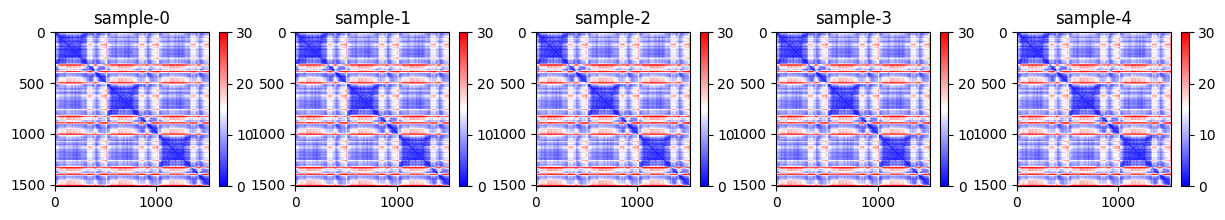

Contact Prob Plots


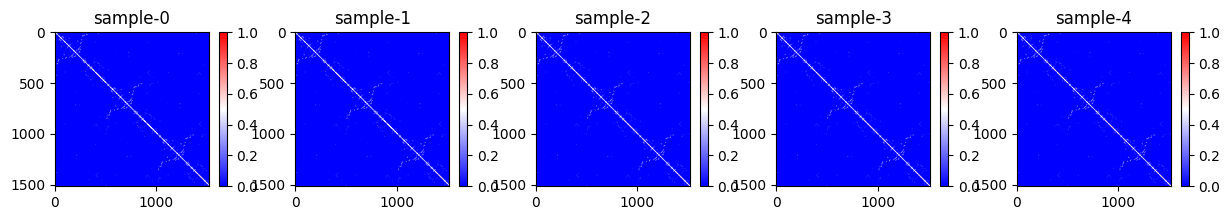

chain pair iptm matrix


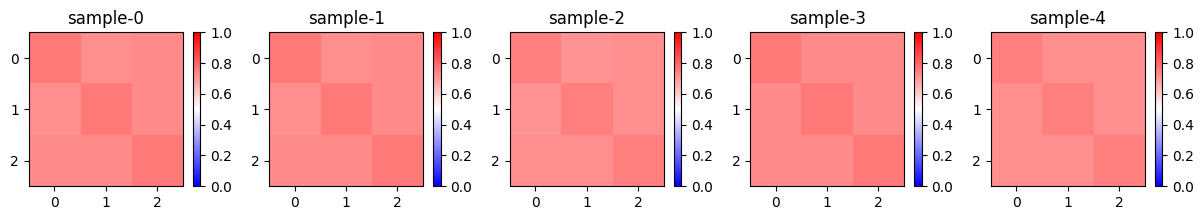

chain pair pae matrix


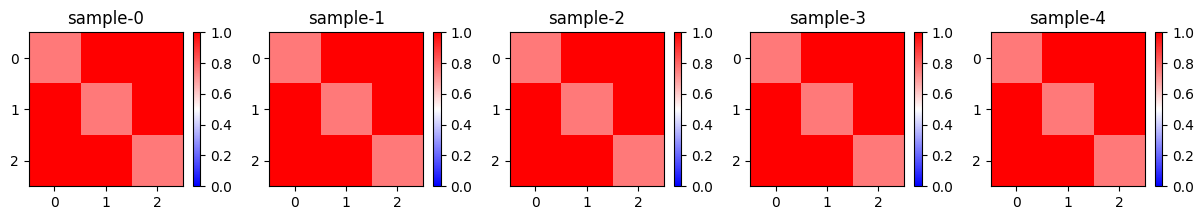

PLDDT Plots


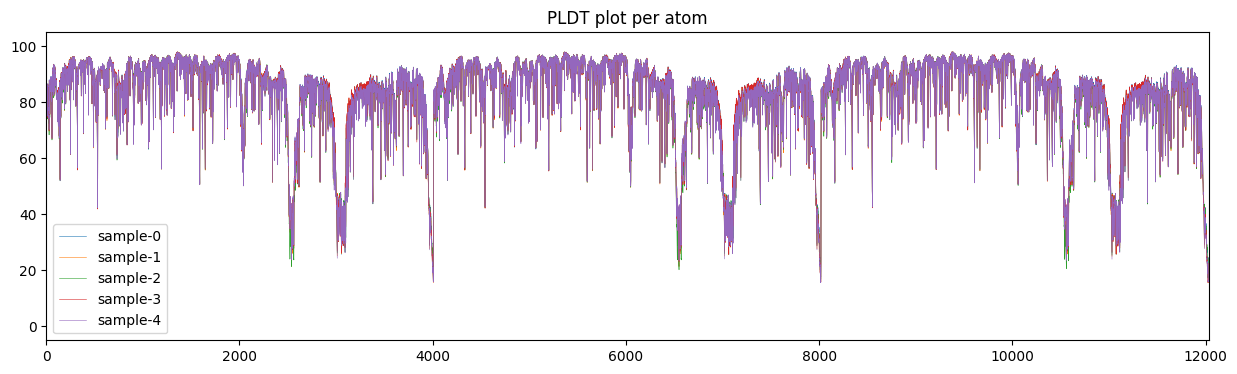

Sequence Coverage Plots
Result Table


<Figure size 1500x800 with 0 Axes>

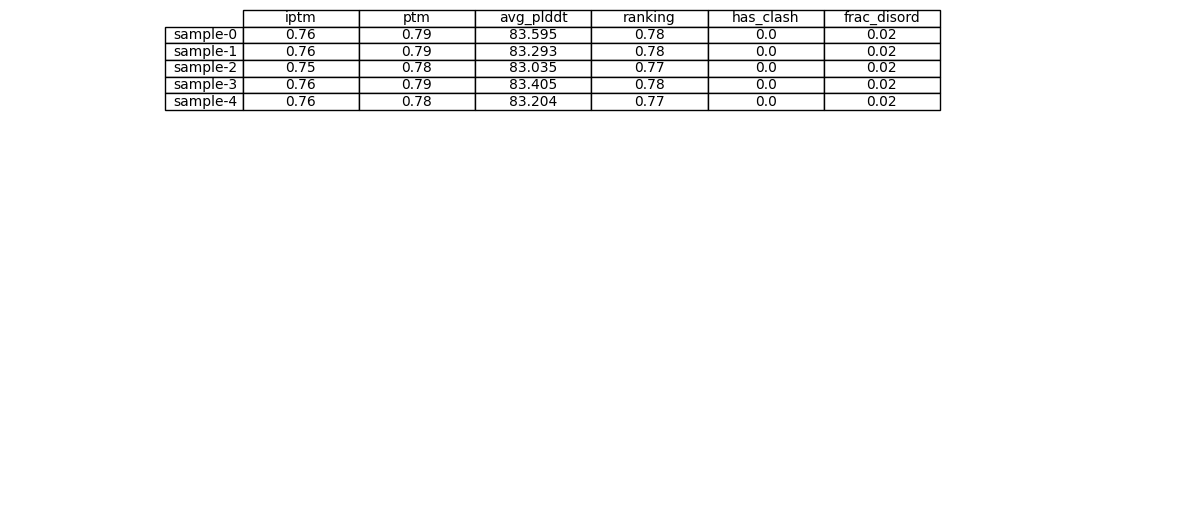

In [ ]:
#@title Summerize Result and Plot
import json
import matplotlib.pyplot as plt
import numpy as np
jobname_input = "" #@param {type:"string"}
Seeds_input = "" #@param {type:"string"}
#@markdown - Just in case. Input these fields to read previous results.

if jobname_input != "" and Seeds_input != "":
  jobname = jobname_input
  Seeds = [int(x) for x in Seeds_input.split(',')]

json_file_path = f'outputs/{jobname.lower()}/{jobname.lower()}_summary_confidences.json'
with open(json_file_path, 'r') as json_file:
  data_list = json.load(json_file)
summary_array = np.array(data_list)

rank = np.loadtxt(f'outputs/{jobname.lower()}/ranking_scores.csv', delimiter = ',', skiprows = 1)
plt.figure(figsize=(15, 2), dpi = 100)

print("The best scored structure is number {0} with score {1}".format(np.argmax(rank[:, 1]) - 1, np.round(np.max(rank[:, 2]), 3)))
print("PAE Plots")
for i in range(5):
  json_file_path = f'outputs/{jobname.lower()}/seed-{Seeds[0]}_sample-{i}/confidences.json'
  with open(json_file_path, 'r') as json_file:
    data_list = json.load(json_file)
  data_array = np.array(data_list)

  plt.subplot(1, 5, i + 1)
  plt.title(f"sample-{i}")
  plt.imshow(data_list["pae"], label=f"sample-{i}", cmap = "bwr", vmin = 0, vmax = 30)
  plt.colorbar()

plt.savefig(f"outputs/{jobname.lower()}/PAE.png")
if show_plots:
  plt.show()
plt.close()

plt.figure(figsize=(15, 2), dpi = 100)
print("Contact Prob Plots")
for i in range(5):
  json_file_path = f'outputs/{jobname.lower()}/seed-{Seeds[0]}_sample-{i}/confidences.json'
  with open(json_file_path, 'r') as json_file:
    data_list = json.load(json_file)
  data_array = np.array(data_list)

  plt.subplot(1, 5, i + 1)
  plt.title(f"sample-{i}")
  plt.imshow(data_list["contact_probs"], label=f"sample-{i}", cmap = "bwr", vmin = 0, vmax = 1)
  plt.colorbar()

plt.savefig(f"outputs/{jobname.lower()}/contact_probs.png")
if show_plots:
  plt.show()
plt.close()

plt.figure(figsize=(15, 2), dpi = 100)
print("chain pair iptm matrix")
for i in range(5):
  json_file_path = f'outputs/{jobname.lower()}/seed-{Seeds[0]}_sample-{i}/summary_confidences.json'
  with open(json_file_path, 'r') as json_file:
    data_list = json.load(json_file)
  data_array = np.array(data_list)

  plt.subplot(1, 5, i + 1)
  plt.title(f"sample-{i}")
  plt.imshow(data_list["chain_pair_iptm"], label=f"sample-{i}", cmap = "bwr", vmin = 0, vmax = 1)
  plt.colorbar()

plt.savefig(f"outputs/{jobname.lower()}/chain_pair_iptm.png")
if show_plots:
  plt.show()
plt.close()

plt.figure(figsize=(15, 2), dpi = 100)
print("chain pair pae matrix")
for i in range(5):
  json_file_path = f'outputs/{jobname.lower()}/seed-{Seeds[0]}_sample-{i}/summary_confidences.json'
  with open(json_file_path, 'r') as json_file:
    data_list = json.load(json_file)
  data_array = np.array(data_list)

  plt.subplot(1, 5, i + 1)
  plt.title(f"sample-{i}")
  plt.imshow(data_list["chain_pair_pae_min"], label=f"sample-{i}", cmap = "bwr", vmin = 0, vmax = 1)
  plt.colorbar()

plt.savefig(f"outputs/{jobname.lower()}/chain_pair_pae_min.png")
if show_plots:
  plt.show()
plt.close()

print("PLDDT Plots")
avg_plddt = []
plt.figure(figsize=(15, 4), dpi = 100)
plt.title(f"PLDT plot per atom")

for i in range(5):
  json_file_path = f'outputs/{jobname.lower()}/seed-{Seeds[0]}_sample-{i}/confidences.json'
  with open(json_file_path, 'r') as json_file:
    data_list = json.load(json_file)
  data_array = np.array(data_list)
  avg_plddt.append(np.mean(data_list["atom_plddts"]))

  plt.plot(data_list["atom_plddts"], label=f"sample-{i}", linewidth = 0.4)
  plt.legend()

plt.xlim(-2, len(data_list["atom_plddts"]) + 2)
plt.ylim(-5, 105)
plt.savefig(f"outputs/{jobname.lower()}/PLDT.png")
if show_plots:
  plt.show()
plt.close()

try:
  print("Sequence Coverage Plots")
  plt.figure(figsize=(15, 8), dpi = 100)

  json_file_path = f'outputs/{jobname.lower()}/{jobname.lower()}_data.json'
  with open(json_file_path, 'r') as json_file:
    data_list = json.load(json_file)
  json_file.close()

  back_plot_array = np.array([[]])
  seq_cov_array = np.array([[]])

  for chains in data_list['sequences']:
    query = chains['protein']['sequence']
    upMsa = np.array(chains['protein']['unpairedMsa'].splitlines()).reshape(-1, 2)[:, 1]
    pMsa = np.array(chains['protein']['pairedMsa'].splitlines()).reshape(-1, 2)[:, 1]
    s = 0

    for k in range(len(upMsa)):
      if len(upMsa[k]) > s:
        s = len(upMsa[k])

    back_plot_array_loc = np.zeros((len(upMsa), s + 1))
    seq_cov_array_loc = np.zeros(s)

    back_plot_array_loc[0:np.size(pMsa), :] = 1
    seq_cov_array_loc = seq_cov_array_loc
    for i in range(len(upMsa) - 1):
      back_plot_array_loc[i, :] = 1 - np.size(np.where(np.array(list(upMsa[i])) == "-")) / len(query)
      back_plot_array_loc[i, np.where(np.array(list(upMsa[i])) == "-")] = 0
      seq_cov_array_loc[np.where(np.array(list(upMsa[i])) != "-")] = seq_cov_array_loc[np.where(np.array(list(upMsa[i])) != "-")] + 1

    back_plot_array_loc = back_plot_array_loc[back_plot_array_loc[:, -1].argsort()]

    if back_plot_array.size == 0:
      back_plot_array = back_plot_array_loc[:, :-1]  # Assign directly if empty
    else:
      # print(np.shape(back_plot_array), np.shape(back_plot_array_loc))
      back_plot_array = np.hstack((back_plot_array, back_plot_array_loc[:, :-1]))

    if seq_cov_array.size == 0:
      seq_cov_array = seq_cov_array_loc  # Assign directly if empty
    else:
      seq_cov_array = np.hstack((seq_cov_array, seq_cov_array_loc))
  plt.title(f"Unpaired Sequence Coverage, Completely paired {np.size(pMsa)} sequences")
  plt.imshow(back_plot_array[::], cmap = "jet_r", origin='lower')
  recover_array = np.zeros((np.shape(back_plot_array)[0], np.shape(back_plot_array)[1], 4))
  recover_array[np.where(back_plot_array == 0)] = np.array([1,1,1,1])
  plt.imshow(recover_array[::], origin='lower')
  plt.plot(seq_cov_array, "k-")
  plt.xlabel("Position")
  plt.ylabel("Matched Unpaired Sequence")
  plt.colorbar()
  plt.savefig(f"outputs/{jobname.lower()}/seq_cov.png")

  if show_plots:
    plt.show()

  plt.close()
except:
  pass

print("Result Table")
iptm = []
ptm = []
ranking = []
has_clash = []
frac_disord = []

for i in range(5):
  json_file_path = f'outputs/{jobname.lower()}/seed-{Seeds[0]}_sample-{i}/summary_confidences.json'
  with open(json_file_path, 'r') as json_file:
    data_list = json.load(json_file)

  iptm.append(data_list["iptm"])
  ptm.append(data_list["ptm"])
  ranking.append(data_list["ranking_score"])
  has_clash.append(data_list["has_clash"])
  frac_disord.append(data_list["fraction_disordered"])

plt.figure(figsize=(15, 4), dpi = 100)
plt.table(cellText = np.transpose([iptm, ptm, np.round(avg_plddt, 3), np.round(ranking, 4), has_clash, frac_disord]),
          colLabels = ["iptm", "ptm", "avg_plddt", "ranking", "has_clash", "frac_disord"],
          colWidths = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
          cellLoc = 'center',
          rowLabels = ["sample-0", "sample-1", "sample-2", "sample-3", "sample-4"],
          loc='top')
plt.axis('off')
plt.savefig(f"outputs/{jobname.lower()}/result.png")
if show_plots:
  plt.show()
plt.close()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

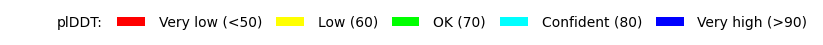

In [ ]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list

color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = True #@param {type:"boolean"}

pdb_filename = f"outputs/{jobname.lower()}/{jobname.lower()}_model.cif"

def show_pdb(jobname, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"outputs/{jobname}/{jobname}_model.cif"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_filename,'r').read(),'cif')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(jobname, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()

In [ ]:
#@title Package Results
import shutil
shutil.make_archive(f"1_Results/{jobname}", 'zip', f"outputs/{jobname.lower()}")

'/app/alphafold/1_Results/XHY052521_73dd2.zip'

## Documentation

[Full Documentation](https://github.com/google-deepmind/alphafold3/blob/main/docs/input.md?plain=1)


Structural templates can be specified only for protein chains:

```json
"templates": [
  {
    "mmcif": ...,
    "queryIndices": [0, 1, 2, 4, 5, 6],
    "templateIndices": [0, 1, 2, 3, 4, 8]
  }
]
```

A template is specified as an mmCIF string containing a single chain with the
structural template together with a 0-based mapping that maps query residue
indices to the template residue indices. The mapping is specified using two
lists of the same length. E.g. to express a mapping `{0: 0, 1: 2, 2: 5, 3: 6}`,
you would specify the two indices lists as:

```json
"queryIndices":    [0, 1, 2, 3],
"templateIndices": [0, 2, 5, 6]
```

You can provide multiple structural templates. Note that if an mmCIF containing
more than one chain is provided, you will get an error since it is not possible
to determine which of the chains should be used as the template.

### Defining Glycans

Glycans are bound to a protein residue, and they are typically formed of
multiple chemical components. To define a glycan, define a new ligand with all
of the chemical components of the glycan. Then define a bond that links the
glycan to the protein residue, and all bonds that are within the glycan between
its individual chemical components.

For example, to define the following glycan composed of 4 components (CMP1,
CMP2, CMP3, CMP4) bound to an asparagine in a protein chain A:

```
 ⋮
ALA            CMP4
 |              |
ASN ―― CMP1 ―― CMP2
 |              |
ALA            CMP3
 ⋮
```

You will need to specify:

1.  Protein chain A.
2.  Ligand chain B with the 4 components.
3.  Bonds ASN-CMP1, CMP1-CMP2, CMP2-CMP3, CMP2-CMP4.

In [10]:
# Clone AlphaFold repository
!git clone https://github.com/deepmind/alphafold.git
%cd alphafold

# Install dependencies
!pip install -r requirements.txt

# Upload your FASTA file
from google.colab import files
uploaded = files.upload()

# Run AlphaFold prediction
!python3 run_alphafold.py --fasta_path=uploaded_file.fasta --model_preset=monomer --use_gpu=True

fatal: could not create work tree dir 'alphafold': File exists
[Errno 2] No such file or directory: 'alphafold'
/content
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


Saving XHY052521_73dd2.json to XHY052521_73dd2.json
python3: can't open file '/content/run_alphafold.py': [Errno 2] No such file or directory
